# **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/My\ Drive/Colab\ Notebooks/

/content/gdrive/My Drive/Colab Notebooks


# **Load dataset**

- Load data from Google Drive, which is created on local laptop.
- In Google Drive, have 3 directories: train_data - valid_data - test_data.
- In each folder, data is stored in h5py format.

In [ ]:
import numpy as np
import h5py

### **Load training set**

In [ ]:
def load_train_dataset():
    X_train = []
    y_train = []

    filename_prefix = 'train_data/X_train_'

    for i in range(1, 11):
        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_train.append(j)

            for j in f['y'][:]:
                y_train.append(j)

    return X_train, y_train

In [ ]:
X_train, y_train = load_train_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...
Loading batch 4 ...
Loading batch 5 ...
Loading batch 6 ...
Loading batch 7 ...
Loading batch 8 ...
Loading batch 9 ...
Loading batch 10 ...


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

**Scale Data: Global Centering**

In [ ]:
mean_train = X_train.mean()
X_train -= mean_train

In [ ]:
y_train_opposite = 1 - y_train
y_train = np.vstack([y_train_opposite, y_train]).T

In [ ]:
print(X_train.shape)
print(y_train.shape)

(194266, 3, 50, 50)
(194266, 2)


### **Load valid set**

In [ ]:
def load_valid_dataset():
    X_valid = []
    y_valid = []

    filename_prefix = 'valid_data/X_valid_'

    for i in range(1, 4):

        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_valid.append(j)

            for j in f['y'][:]:
                y_valid.append(j)

    return X_valid, y_valid

In [ ]:
X_valid, y_valid = load_valid_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [ ]:
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [ ]:
mean_valid = X_valid.mean()
X_valid -= mean_valid

In [ ]:
y_valid_opposite = 1 - y_valid
y_valid = np.vstack([y_valid_opposite, y_valid]).T

In [ ]:
print(X_valid.shape)
print(y_valid.shape)

(41629, 3, 50, 50)
(41629, 2)


### **Load test set**

In [ ]:
def load_test_dataset():
    X_test = []
    y_test = []

    filename_prefix = 'test_data/X_test_'

    for i in range(1, 4):

        
        filename = filename_prefix + str(i) + '.hdf5'
        print('Loading batch ' + str(i) + ' ...')

        with h5py.File(filename, 'r') as f:
            for j in f['X'][:]:
                X_test.append(j)

            for j in f['y'][:]:
                y_test.append(j)

    return X_test, y_test

In [ ]:
X_test, y_test = load_test_dataset()

Loading batch 1 ...
Loading batch 2 ...
Loading batch 3 ...


In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
mean_test = X_test.mean()
X_test -= mean_test

In [ ]:
label = y_test

In [ ]:
y_test_opposite = 1 - y_test
y_test = np.vstack([y_test_opposite, y_test]).T

In [ ]:
print(X_test.shape)
print(y_test.shape)

(41629, 3, 50, 50)
(41629, 2)


# **Building Model Capsule Neural Network**

In [ ]:
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

USE_CUDA = True

### **Parameters of the model**

In [ ]:
EPOCHS = 25
BATCH_SIZE = 128

### **Defining the Model**

- The CapsNet architecture consists of an **Encoder** and a **Decoder**, where each has a set of three layers. 
- An Encoder has a **Convolutional layer**, **PrimaryCaps layer**, and a **DigitCaps layer**.
- A Decoder has 3 fully-connected layers.

### **Convolution Layer**

- This is a usual convolution layer that extracts basic features from images.
- Input model is RGB image data (3 color channels, 50 pixels height, 50 pixels width)
- Transform input image to multi-dimensional matrix with size 3 - 50 - 50.
- **Convolution Layer 1st**
  - Transform each area of pixels with: kernel_size = 7, stride = 1, output channel = 64. 
  - Obtain multi-dimensional matrix with size 64 - 44 - 44.
- **Convolution Layer 2nd**
  - Transform each area of pixels with: kernel_size = 7, stride = 1, output channel = 256. 
  - Obtain multi-dimensional matrix with size 256 - 38 - 38.


In [ ]:
class ConvLayer(nn.Module):
  
    def __init__(self, in_channels=3, mid_channels=64, out_channels=256, kernel_size=7):
        super(ConvLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=kernel_size, stride=1)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1)

    def forward(self, x):
        return F.relu(self.conv2(self.conv1(x)))

### **Primary Capsule Layer**
- Consists of 3 components:
  - Convolution
  - Reshape
  - Squash
- The **PrimaryCaps layer** is a convolutional layer that has 16 channels of convolutional 16-D capsules.
- **Squash Function**
  - The length of the output vector of a capsule presents the probability of the entity present in current input that particular capsule is looking for and the orientation of this output vector estimates pose parameters. To achieve this functionality we apply a non-linear ‘squashing’ activation function to ensure the length of vector in between 0-1 where short vectors get shrunk to almost zero length and long vectors get shrunk to a length slightly below 1.

  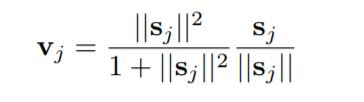

  - Note: The derivative of ||sj|| is undefined when ||sj||=0. During training if a vector is zero, the gradients will be nan. To avoid this situation we add a tiny epsilon with squared norm then apply square root.

    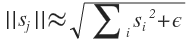

In [ ]:
class PrimaryCaps(nn.Module):
  
    def __init__(self, num_capsules=16, in_channels=256, out_channels=16, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 16*15*15, -1)
        return self.squash(u)
    
    def squash(self, input_tensor, eps=1e-7):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + eps))
        return output_tensor

### **Digit Capsule Layer**

-  The DigitCaps layer has 32-D capsules per class, where each capsule receives input from the low-level capsule.
- Every capsule in the Primary layer tries to predict the output of every capsule in Digit layer. Output of primary capsules only send to those capsule in Digit capsule, if primary capsules prediction agrees with the ouput of digit capsule. We take this decision by ‘Routing By Agreement’. Digit capsules will get only the appropriate output from primary capsules and more accurately determine the spatial information. We route only between primary and digit capsule because first convolution layer encode lower level features, there is no spatial information in its space to agree on.
- Below you may see the dynamic routing algorithm from the original paper:

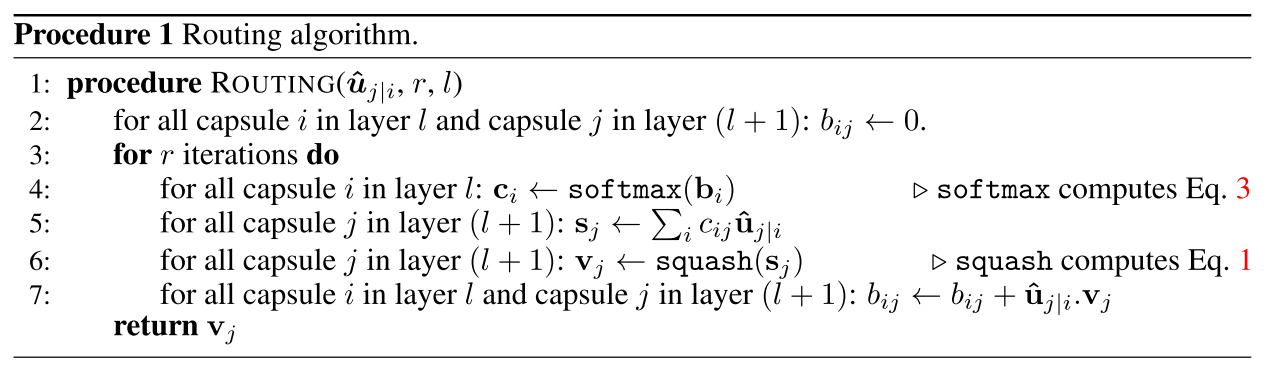

In [ ]:
class DigitCaps(nn.Module):
  
    def __init__(self, num_capsules=2, num_routes=16*15*15, in_channels=16, out_channels=32):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor, eps=1e-7):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + eps))
        return output_tensor

### **Decoder**

- Decoder part consist of three Fully Connected layers. A decoder takes the correct 32-D capsule and decodes it into an image.
- A decoder has three fully-connected layers. The first layer has 512 neurons; the second has 1024 neurons; and the third has 7500 neurons.

In [ ]:
class Decoder(nn.Module):
  
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(32 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 50*50*3),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(2))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        reconstructions = self.reconstruction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 3, 50, 50)
        
        return reconstructions, masked

### **Full network (CapsNet)**

This is a final forward pass for the whole network. The only new part here is the custom loss from the original paper.

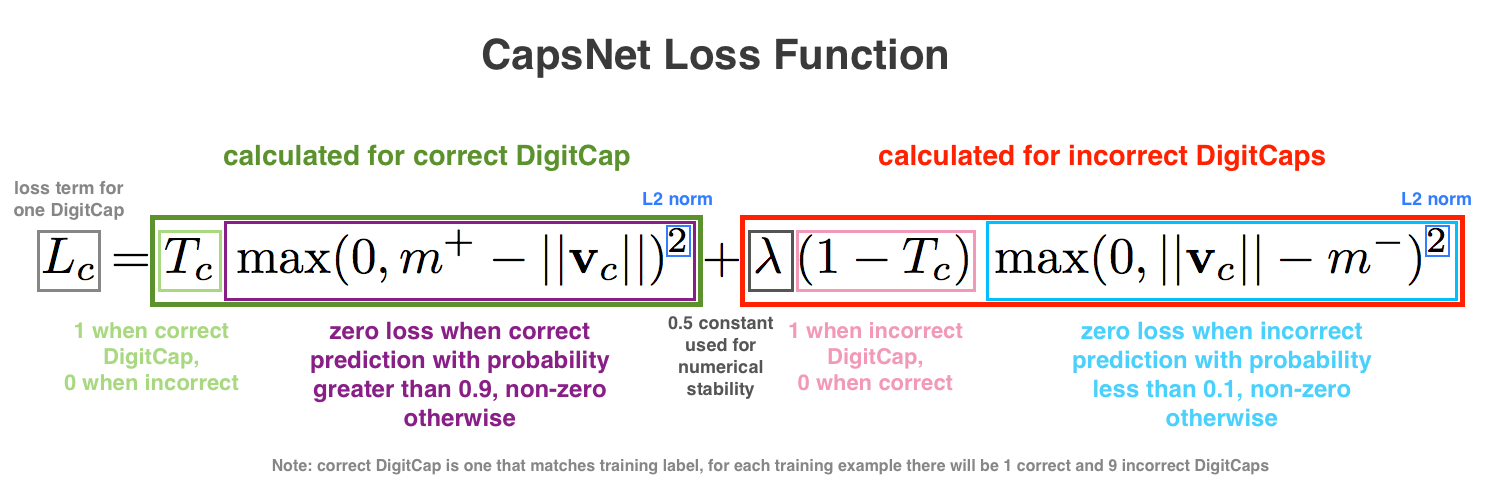

In [ ]:
class CapsNet(nn.Module):
  
    def __init__(self):
        super(CapsNet, self).__init__()

        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

In [ ]:
model = CapsNet()
print(model)

CapsNet(
  (conv_layer): ConvLayer(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (conv2): Conv2d(64, 256, kernel_size=(7, 7), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (8): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (9): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (10): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (11): Conv2d(256, 16, kernel_size=(9, 9), stride=(2, 2))
      (12): Conv2d(256, 1

**Calculate the number of trainable parameters (weights and biases)**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 18,053,708 trainable parameters


**Optimization Algorithm**

- **Adam** (Adaptive Moment Estimation) works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search.

- Advantages:
  + The method is too fast and converges rapidly.
  + Rectifies vanishing learning rate, high variance.

- Disadvantages:
  + Computationally costly.

In [ ]:
optimizer = optim.Adam(model.parameters())

**Create mini-batch**

In [ ]:
def next_batch(X, y, batch_size):
    # Mini-batch
    for i in np.arange(0, X.shape[0], batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

**Transform the model and data to GPU**

In [ ]:
if USE_CUDA:
    model = model.cuda()

### **Training the Model**

**Define Traning step**
- Put the model into train mode: **model.train()**
- Iterate over batches of data.
- Transform the batch to GPU mode.
- Clear the gradients calculated from the last batch.
- Impliment model for batch of images: x, get predictions, y_pred.
- Calculate the loss between prediction labels and the actual labels.
- Calculate the accuracy between prediction labels and the actual labels.
- Calculate the gradients of each parameter.
- Update the parameters by taking optimizer step.
- Return the loss and the accuracy of epoch.

In [ ]:
def train(model, X, y, optimizer, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment train mode
    model.train()
    
    for (batchX, batchY) in next_batch(X, y, batch_size):
        data = torch.from_numpy(batchX)
        target = torch.from_numpy(batchY)
        size = target.shape[0]

        data, target = Variable(data), Variable(target)
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        
        # Clear the gradients calculated from the last batch
        optimizer.zero_grad()
                
        output, reconstructions, masked = model(data)

        loss = model.loss(data, output, target, reconstructions)
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        
        # Calculate the gradients of each parameter
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += correct / float(size)
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Define Evaluation step**

- Similar the training step. The differences are:
  + Put the model into evalution mode: **model.eval()**
  + Don't calculate the gradients of each parameter.
  + Don't update the parameters by taking optimizer step.

In [ ]:
def evaluate(model, X, y, batch_size):
    epoch_loss = 0
    epoch_acc = 0
    
    # Impliment evaluation mode
    model.eval()
    
    for (batchX, batchY) in next_batch(X, y, batch_size):
        data = torch.from_numpy(batchX)
        target = torch.from_numpy(batchY)
        size = target.shape[0]

        data, target = Variable(data), Variable(target)
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        
        output, reconstructions, masked = model(data)

        loss = model.loss(data, output, target, reconstructions)
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))

        epoch_loss += loss.item()
        epoch_acc += correct / float(size)
        
    num_of_batchs = math.ceil(len(X) / batch_size)
    return epoch_loss / num_of_batchs, epoch_acc / num_of_batchs

**Calculate the time need to run each epoch**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training the Model**
- Iterate over epochs.
- In each epochs:
  - Training the Model with training set.
  - Evaluate the Model with validation set.
  - Check the best validation loss and save the model parameters
  - Print the result metrics: Loss and Accuracy.

In [ ]:
best_valid_loss = float('inf')
train_loss_list = list()
valid_loss_list = list()

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, X_train, y_train, optimizer, batch_size=BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, X_valid, y_valid, batch_size=BATCH_SIZE)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'caps_model.pt')
    
    end_time = time.monotonic()            

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 9m 59s
	Train Loss: 0.244 | Train Acc: 79.74%
	 Val. Loss: 0.191 |  Val. Acc: 83.93%
Epoch: 02 | Epoch Time: 9m 59s
	Train Loss: 0.184 | Train Acc: 83.56%
	 Val. Loss: 0.182 |  Val. Acc: 84.78%
Epoch: 03 | Epoch Time: 9m 57s
	Train Loss: 0.176 | Train Acc: 84.26%
	 Val. Loss: 0.176 |  Val. Acc: 84.90%
Epoch: 04 | Epoch Time: 9m 58s
	Train Loss: 0.171 | Train Acc: 84.56%
	 Val. Loss: 0.173 |  Val. Acc: 85.21%
Epoch: 05 | Epoch Time: 9m 58s
	Train Loss: 0.168 | Train Acc: 84.92%
	 Val. Loss: 0.168 |  Val. Acc: 85.38%
Epoch: 06 | Epoch Time: 9m 58s
	Train Loss: 0.162 | Train Acc: 85.56%
	 Val. Loss: 0.163 |  Val. Acc: 86.01%
Epoch: 07 | Epoch Time: 9m 58s
	Train Loss: 0.158 | Train Acc: 86.03%
	 Val. Loss: 0.158 |  Val. Acc: 86.25%
Epoch: 08 | Epoch Time: 9m 58s
	Train Loss: 0.156 | Train Acc: 86.29%
	 Val. Loss: 0.159 |  Val. Acc: 86.26%
Epoch: 09 | Epoch Time: 10m 2s
	Train Loss: 0.153 | Train Acc: 86.48%
	 Val. Loss: 0.156 |  Val. Acc: 86.41%
Epoch: 10 | Epoch T

**Load the parameters of the best model and evaluate the model on the test set**

In [ ]:
model.load_state_dict(torch.load('caps_model.pt'))

test_loss, test_acc = evaluate(model, X_test, y_test, batch_size=BATCH_SIZE)

**Test Loss**

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.148 | Test Acc: 87.41%


### **Examining the Model**

**Visualizing loss of train set and valid set**

In [ ]:
epoch_list = np.arange(1, 26)

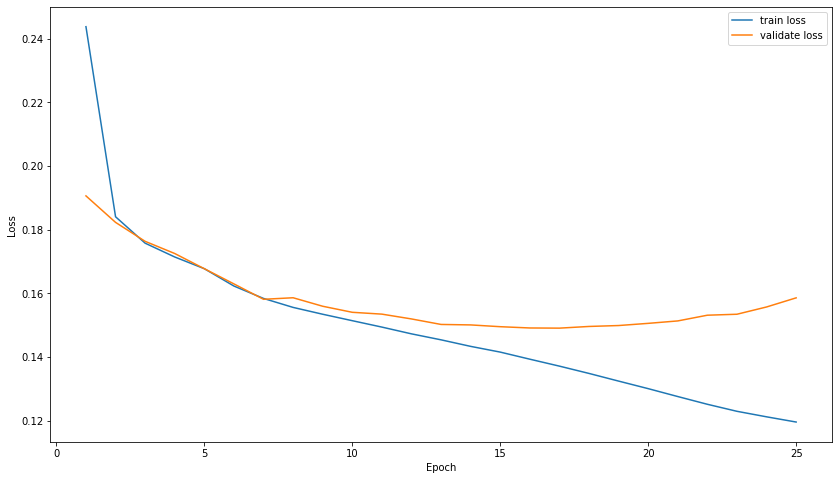

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(epoch_list, train_loss_list, label='train loss')
ax.plot(epoch_list, valid_loss_list, label='validate loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()
plt.show()

**Get the predictions of all dataset**

In [ ]:
def get_predictions(model, X, y, batch_size):
    
    model.eval()
    predict_label = []

    for (batchX, batchY) in next_batch(X, y, batch_size):
        data = torch.from_numpy(batchX)

        data = Variable(data)
        if USE_CUDA:
            data = data.cuda()
        
        output, reconstructions, masked = model(data)
        top_pred = masked.argmax(1, keepdim = True)

        for i in top_pred:
            predict_label.append(i.item())

    return np.array(predict_label)

In [ ]:
predict_label = get_predictions(model, X_test, y_test, batch_size=BATCH_SIZE)

**Confusion matrix**

In [ ]:
cm = confusion_matrix(label, predict_label)
print(cm)

[[26769  2946]
 [ 2286  9628]]


In [ ]:
pd_cm = pd.DataFrame(cm, index = ['negative', 'positive'], columns = ['negative', 'positive'])

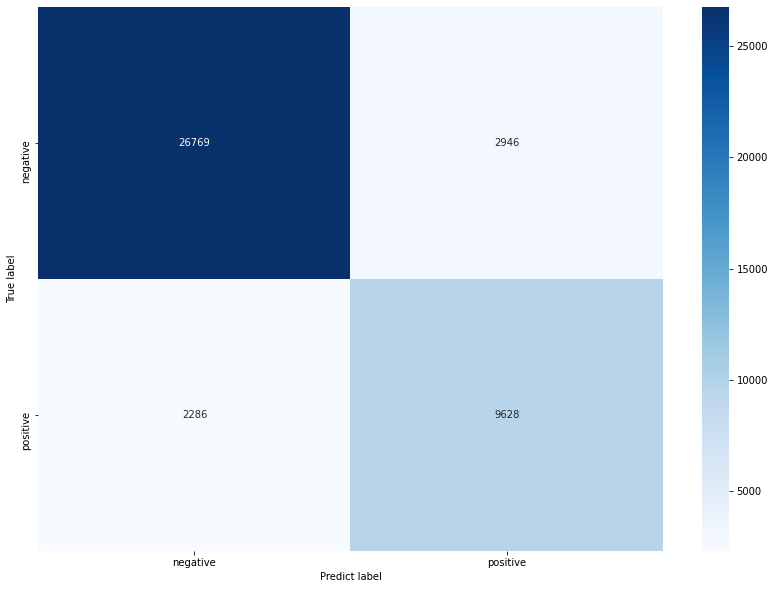

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.axes()
sn.heatmap(pd_cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')

plt.show()

**F1 score**

In [ ]:
fs = f1_score(label, predict_label)
print(f'F1 score: {fs:.2f}')

F1 score: 0.79


**Recall score**

In [ ]:
rs = recall_score(label, predict_label)
print(f'Recall score: {rs:.2f}')

Recall score: 0.81
